In [42]:
import numpy as np
from matplotlib import pyplot as plt

from os import listdir
from os.path import join
from scipy.io import wavfile

import sys
import math

import librosa
import librosa.display
from librosa.effects import trim

import tensorflow as tf
import tensorflow_io as tfio
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Resizing, Input
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import layers, models
from keras.optimizers import Adam


import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import make_scorer, recall_score

import itertools  

import IPython.display as ipd
from IPython.core.display import display
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


/tmp/ipykernel_3461/3884568444.py:33: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


# Util functions

In [3]:
# by default anything below 10 db is considered as silence
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    # Trim the beginning and ending silence
    yt, _ = trim(sample, top_db= top_db)
    return yt

In [4]:
def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

In [5]:
def stft_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([max_size] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [6]:
def mel_spectrogram(waveform):
    spec = librosa.feature.melspectrogram(y=waveform, sr=8000)
    return librosa.power_to_db(spec, ref=np.max)

In [7]:
def mfcc_spectrogram(waveform):
    """Mel-Frequency Cepstral Coefficients (MFCCs)"""
    spec = librosa.feature.mfcc(y=waveform, sr=8000)
    return spec

In [8]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [9]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [10]:
def get_white_noise(signal,SNR) :
    RMS_s=math.sqrt(np.mean(signal.astype(np.int32)**2))
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [11]:
def add_noise(data):  
    newdata = []
    for audio in data:
        noise = get_white_noise(audio, 3)
        newdata.append(audio + noise)
    
    return newdata

In [12]:
def change_pitch(data): 
    newdata = []
    for audio in data:
        newdata.append(librosa.effects.pitch_shift(audio.astype(np.float64), sr=8000, n_steps=3))
    
    return newdata

In [13]:
def stretch(data): 
    newdata = []
    for audio in data:
        newdata.append( librosa.effects.time_stretch(audio.astype(np.float64), rate=0.5) ) 
        newdata.append( librosa.effects.time_stretch(audio.astype(np.float64), rate=1.4) )
    
    return newdata

In [14]:
def data_augmentation(X, y, *, noise=False, pitch=False, time_stretch=False):
    X2 = [*X]
    y2 = [*y]
    display(ipd.Audio(X2[-1], rate=8000))
    
    if pitch:
        print('Pitch')
        X2 += change_pitch(X)
        y2 += y
        display(ipd.Audio(X2[-1], rate=8000))
        
        plt.plot(X2[inv_longest_audio])
        plt.title("Longest audio signal after Pitch Shift")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.show()
      
    if time_stretch:
        print('Time Stretch')
        X2 += stretch(X)
        y2 += 2*y
        display(ipd.Audio(X2[-len(X) - 1], rate=8000))
        display(ipd.Audio(X2[-1], rate=8000))
        
        plt.plot(X2[-len(X) + inv_longest_audio])
        plt.title("Longest audio signal after Time Stretch of x0.5")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.show()
        
        plt.plot(X2[inv_longest_audio])
        plt.title("Longest audio signal after Time Stretch of x1.4")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")#X = np.array([time_mask(freq_mask(x)) for x in X])
        plt.show()
        
    if noise:
        print('Noise')
        X2 += add_noise(X) 
        y2 += y
        display(ipd.Audio(X2[-1], rate=8000))
        
        plt.plot(X2[inv_longest_audio])
        plt.title("Longest audio signal after Adding Noise")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.show()
        
    return X2, y2

In [15]:
def freq_mask(spec):
    return tfio.audio.freq_mask(spec, param=4).numpy()

In [16]:
def time_mask(spec):
    return tfio.audio.time_mask(spec, param=4).numpy()

# Data Setup

## Get the audio files

In [17]:
files = 'recordings/'
ds_files = listdir(files)

labels = [str(i) for i in range(10)]
rate = 8000

X = []
y = []

for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))
    
    X.append(data.astype(float))
    y.append(label)
    

min_size = 100000
for x in X:
    min_size = min(min_size, x.shape[0])
print(min_size)


1148


# Data Augmentation

Augment the data, by stretching it, adding white noise, and pitch shifting it.

Pitch


/home/leikrad/Projects/TAA/TAA_Projects/project_2/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1933
  warnings.warn(
/home/leikrad/Projects/TAA/TAA_Projects/project_2/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1399
  warnings.warn(
/home/leikrad/Projects/TAA/TAA_Projects/project_2/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(
/home/leikrad/Projects/TAA/TAA_Projects/project_2/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1983
  warnings.warn(
/home/leikrad/Projects/TAA/TAA_Projects/project_2/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.w

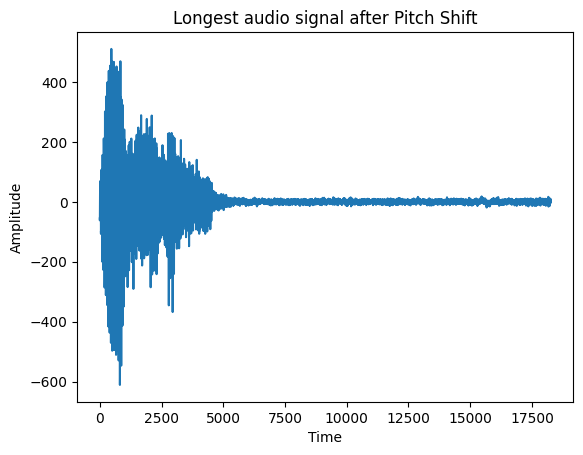

Time Stretch


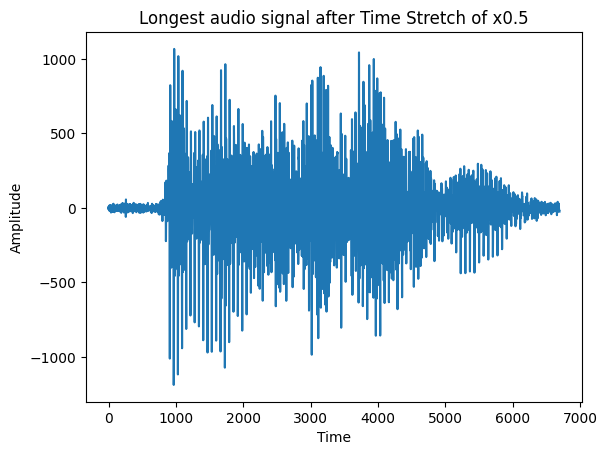

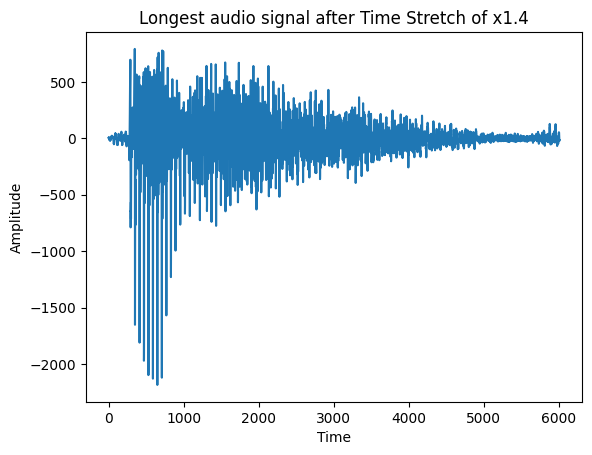

Noise


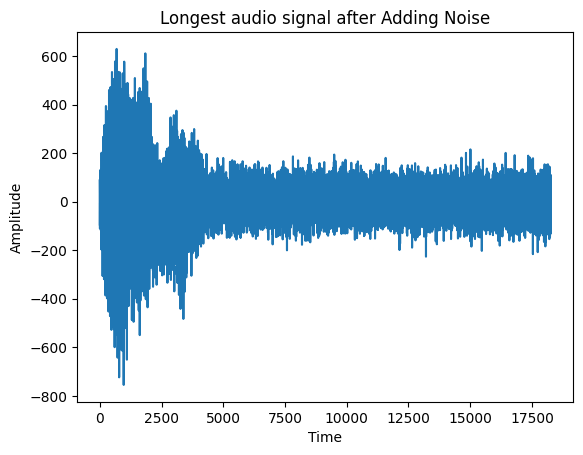

15000 15000


In [18]:
inv_longest_audio = - (len(X) - np.argmax([len(x) for x in X]))

X, y = data_augmentation(X, y, noise=True, pitch=True, time_stretch=True)

print(len(X), len(y))

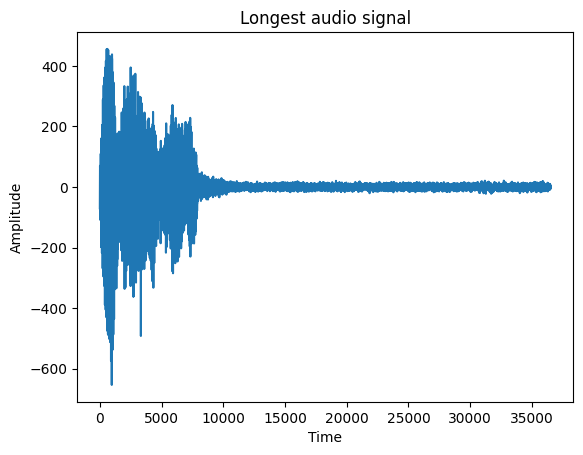

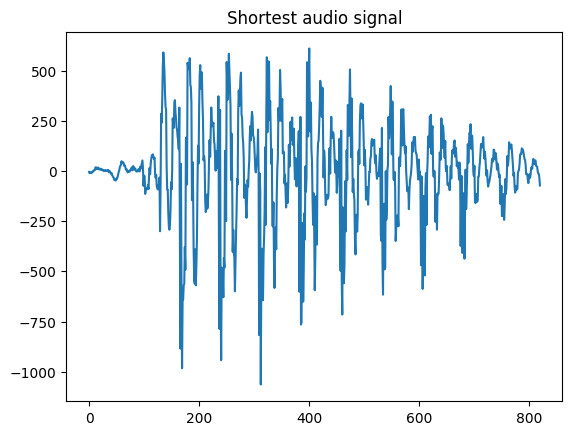

Max sizing before: 36524
Max sizing after: 12800


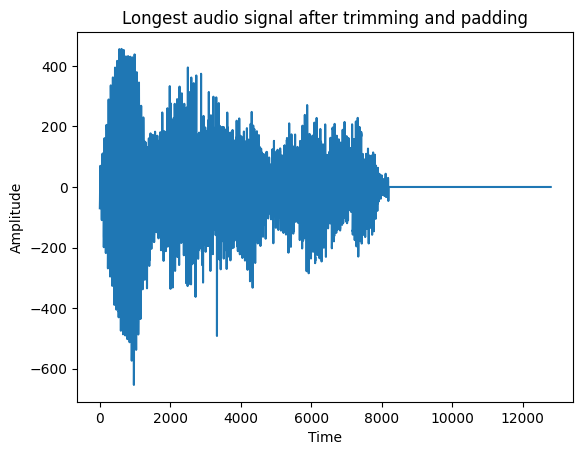

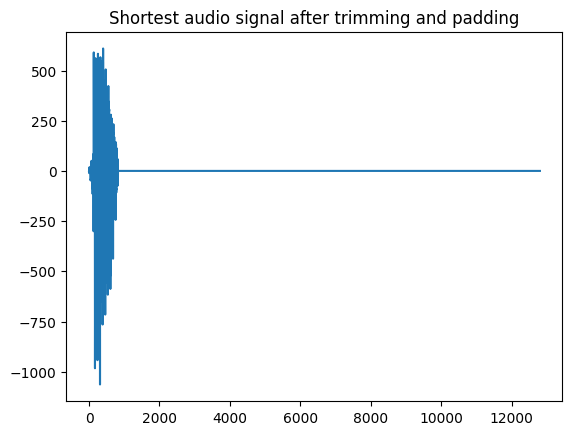

In [19]:
longest_audio = np.argmax([len(x) for x in X])
plt.plot(X[longest_audio])
plt.title("Longest audio signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

display(ipd.Audio(X[longest_audio], rate=rate))

shortest_audio = np.argmin([len(x) for x in X])
plt.plot(X[shortest_audio])
plt.title("Shortest audio signal")
plt.show()

display(ipd.Audio(X[shortest_audio], rate=rate))


max_size = 0
for x in X:
    max_size = max(max_size, x.shape[0])
    
print('Max sizing before:', max_size)

# trim silence
X = [ remove_silence(x) for x in X ]


# add padding to max size
max_size = 0
for x in X:
    max_size = max(max_size, x.shape[0])
    
print('Max sizing after:', max_size)
    
X = [ np.pad(x, (0, max_size - x.shape[0])) for x in X ]

plt.plot(X[longest_audio])
plt.title("Longest audio signal after trimming and padding")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

display(ipd.Audio(X[longest_audio], rate=rate))

plt.plot(X[shortest_audio])
plt.title("Shortest audio signal after trimming and padding")
plt.show()

display(ipd.Audio(X[shortest_audio], rate=rate))

(128, 26)
(20, 26)


[Text(0.5, 1.0, 'MFCC Spectrogram with Freq. and Time Mask')]

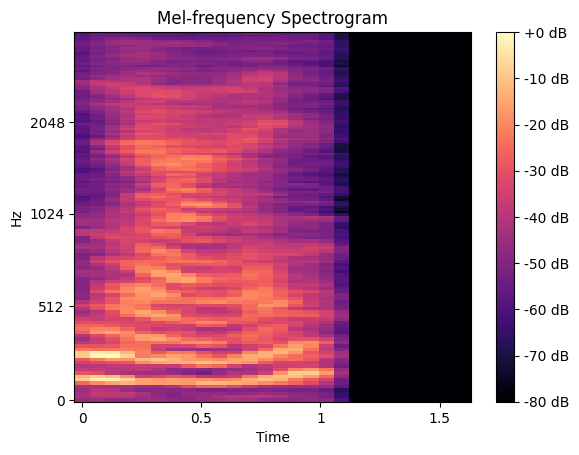

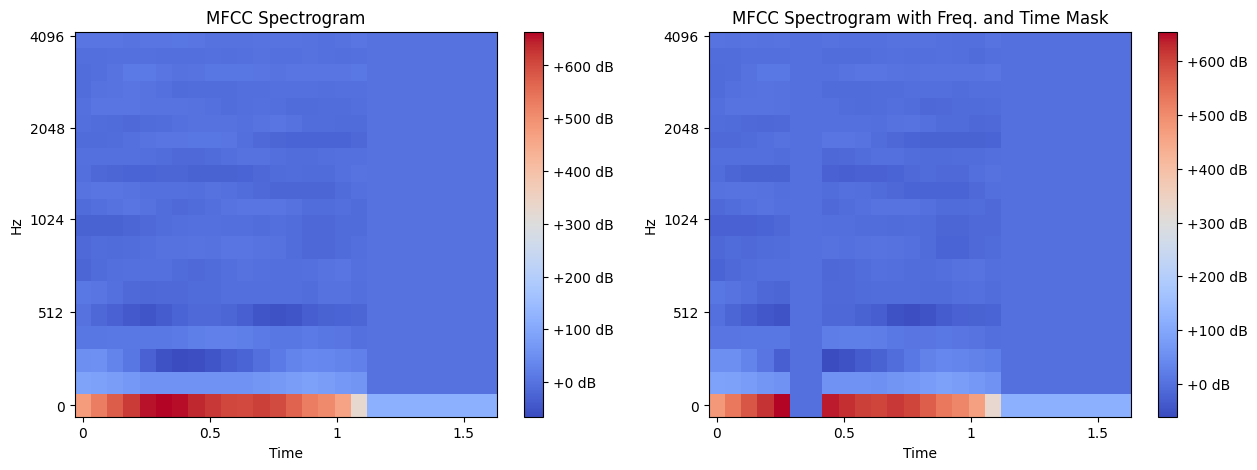

In [20]:
#librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=512,n_mfcc=128)

#spec = librosa.stft(X[1500])

wave = X[longest_audio]

S = mel_spectrogram(wave)
print(S.shape)

fig, ax = plt.subplots()

img = librosa.display.specshow(S, x_axis='time',
                         y_axis='mel', sr=rate, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency Spectrogram')



S = mfcc_spectrogram(wave)
print(S.shape)


fig, ax = plt.subplots(1,2)

img = librosa.display.specshow(S, x_axis='time',
                         y_axis='mel', sr=rate, ax=ax[0])
fig.colorbar(img, ax=ax[0], format='%+2.0f dB')
ax[0].set(title='MFCC Spectrogram')


S2 = freq_mask(time_mask(S))

#fig, ax = plt.subplots()

img = librosa.display.specshow(S2, x_axis='time',
                         y_axis='mel', sr=rate, ax=ax[1])

fig.colorbar(img, ax=ax[1], format='%+2.0f dB')
fig.set_size_inches(15, 5)
ax[1].set(title='MFCC Spectrogram with Freq. and Time Mask')


(99, 129)


/tmp/ipykernel_3461/2306894922.py:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


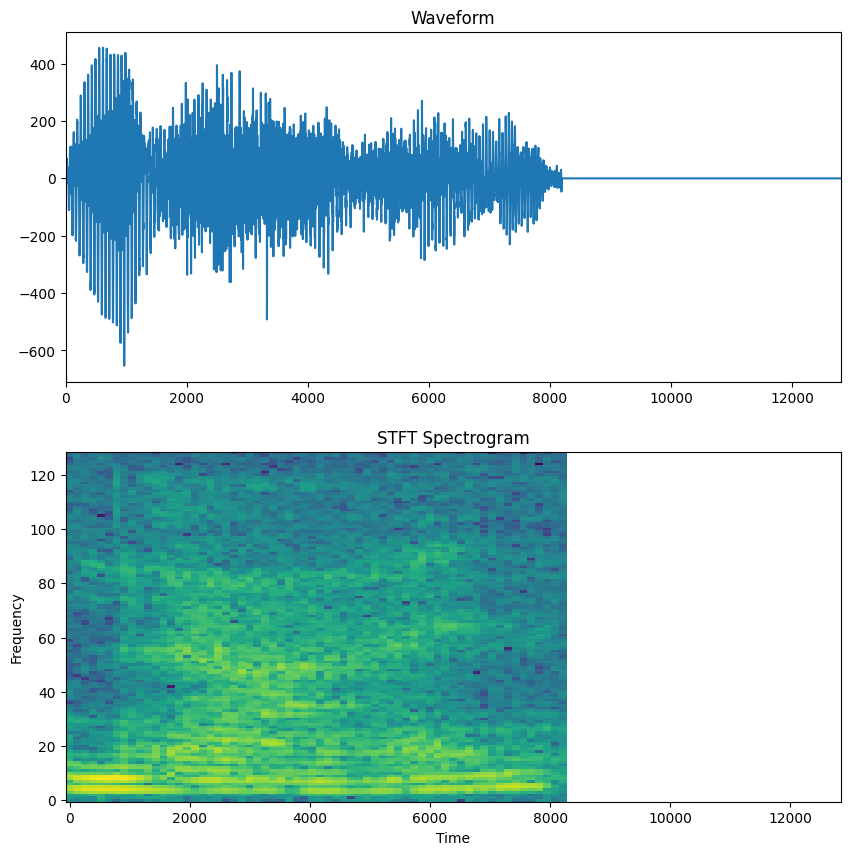

In [21]:
waveform = X[longest_audio]

spectrogram = stft_spectrogram(waveform).numpy()

#spectrogram.resize(32, 32)
print(spectrogram.shape)

timescale = np.arange(waveform.shape[0])
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, max_size])

fig.set_size_inches(10, 10)

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Frequency')
axes[1].set_title('STFT Spectrogram')

plot_spectrogram(spectrogram, axes[1])


In [22]:
# try different spec
X = np.array([mfcc_spectrogram(x) for x in X])


Number of training examples:  9000
Number of validation examples:  3000
Number of test examples:  3000
Percentage of positive examples in training set:  450.1666666666667
Percentage of positive examples in validation set:  441.1333333333333
Percentage of positive examples in test set:  458.3666666666667


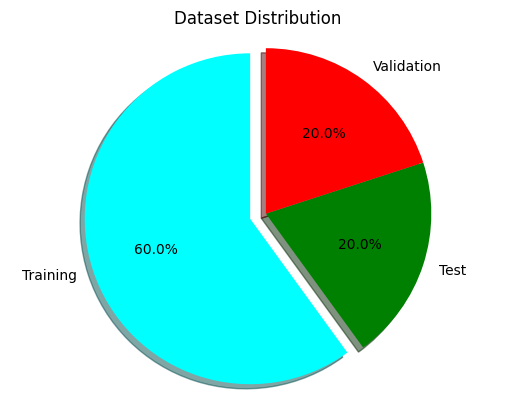

In [51]:
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

x_train_cur = x_train
x_val_cur = x_val
x_test_cur = x_test

print("Number of training examples: ", len(y_train))
print("Number of validation examples: ", len(y_val))
print("Number of test examples: ", len(y_test))

# get percentage of positive examples in each set
print("Percentage of positive examples in training set: ", np.sum(y_train)/len(y_train)*100)
print("Percentage of positive examples in validation set: ", np.sum(y_val)/len(y_val)*100)
print("Percentage of positive examples in test set: ", np.sum(y_test)/len(y_test)*100)

# percentage 
train_percentage = len(y_train)/len(y)*100
val_percentage = len(y_val)/len(y)*100
test_percentage = len(y_test)/len(y)*100

labels = 'Training', 'Test', 'Validation'
sizes = [train_percentage, test_percentage, val_percentage]
colors = ['cyan', 'green', 'red']
explode = (0.1, 0, 0)  # only "explode" the 1st slice (training)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Dataset Distribution')
plt.show()

In [27]:
# Neural Network (NN) with multiple hidden layers
def network_builder(hidden_dimensions, droppout, input_dim):
    input_shape = x_train_cur.shape
    num_labels = 10
    hidden_dimensions = [512,512]
    # create model
    model = Sequential()
    model.add(Input(shape=(*x_train_cur[0].shape, 1))),
    model.add(Resizing(32, 32),)
    model.add(Conv2D(32, 3, activation='relu'),)
    model.add(MaxPooling2D(),)
    model.add(Dropout(droppout[0]),)
    model.add(Flatten(),)
    print(hidden_dimensions)
    for dimension in hidden_dimensions[:]:
        model.add(Dense(dimension, kernel_initializer='normal', activation='relu'))

    model.add(Dense(num_labels, activation='softmax')),
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])
    return model

# 97 1 1 0.2
# 97 1 1 0.5

In [30]:
# Find the best hyper-parameter (hidden layer dimensions) optimizing for recall
def print_gridsearch_scores_deep_learning(x_train_data,y_train_data):
    scorer = make_scorer(recall_score, average='micro')  # change 'micro' to whatever you want
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
#verbose=1 will show an animated progress bar ------------- during training 
#verbose=0  does not show anything during training 
    
# choose between 3 options for "hidden_dimensions": 
# [10] - 1 hidden layer with 10 units; 
# [10, 10, 10] - 3 hidden layers with 10 units each; 
# [100, 10] - 2 hidden layers with 100 units in 1st & 10 units 2nd layer; 
    
    
    # clf = GridSearchCV(KerasClassifier(model=network_builder, epochs=150, batch_size=128, 
    #     verbose=1, input_dim=0, hidden_dimensions=[10]), {"hidden_dimensions": ([8],[16],[32],[64],[128],[128 ,8],[128 ,16],[128 ,32],[128,64], [128,128])}, cv=5, scoring=scorer)

    """Best parameters found on development set:

        {'hidden_dimensions': [128, 128]}
        Grid scores on development set:
        0.105 (+/-0.000) for {'hidden_dimensions': [8]}
        0.105 (+/-0.000) for {'hidden_dimensions': [16]}
        0.131 (+/-0.105) for {'hidden_dimensions': [32]}
        0.482 (+/-0.511) for {'hidden_dimensions': [64]}
        0.833 (+/-0.030) for {'hidden_dimensions': [128]}
        0.105 (+/-0.000) for {'hidden_dimensions': [128, 8]}
        0.105 (+/-0.000) for {'hidden_dimensions': [128, 16]}
        0.257 (+/-0.608) for {'hidden_dimensions': [128, 32]}
        0.859 (+/-0.012) for {'hidden_dimensions': [128, 64]}
        0.861 (+/-0.014) for {'hidden_dimensions': [128, 128]}
    """
    # clf = GridSearchCV(KerasClassifier(model=network_builder, epochs=150, batch_size=128, 
    #     verbose=0, input_dim=0, hidden_dimensions=[10]), {"hidden_dimensions": ([128],[256],[512],[128,128],[128,256],[128,512],[256,128],[256,256],[512,128],[512,256],[512,512])}, cv=5, scoring=scorer)

    """
        0.819 (+/-0.041) for {'hidden_dimensions': [128]}
        0.858 (+/-0.017) for {'hidden_dimensions': [256]}
        0.864 (+/-0.004) for {'hidden_dimensions': [512]}
        0.861 (+/-0.006) for {'hidden_dimensions': [128, 128]}
        0.857 (+/-0.022) for {'hidden_dimensions': [128, 256]}
        0.853 (+/-0.009) for {'hidden_dimensions': [128, 512]}
        0.872 (+/-0.006) for {'hidden_dimensions': [256, 128]}
        0.869 (+/-0.010) for {'hidden_dimensions': [256, 256]}
        0.722 (+/-0.618) for {'hidden_dimensions': [512, 128]}
        0.876 (+/-0.019) for {'hidden_dimensions': [512, 256]}
        0.878 (+/-0.014) for {'hidden_dimensions': [512, 512]}
"""
    clf = GridSearchCV(KerasClassifier(model=network_builder, epochs=150, batch_size=128, 
        verbose=0, input_dim=0, hidden_dimensions=[10], droppout=[0.1]), {"droppout" : ([0.1],[0.2],[0.3],[0.4],[0.5])}, cv=5, scoring=scorer)
    """Best parameters found on development set:

        'droppout': [0.5]}
        rid scores on development set:
        .868 (+/-0.014) for {'droppout': [0.1]}
        .863 (+/-0.022) for {'droppout': [0.2]}
        .867 (+/-0.017) for {'droppout': [0.3]}
        .878 (+/-0.007) for {'droppout': [0.4]}
        .878 (+/-0.022) for {'droppout': [0.5]}
    """
    
    clf.fit(x_train_data,y_train_data, callbacks=[early_stopping])

    print("Best parameters found on development set:")
    print()
    print(clf.best_params_)

    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print( "%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params) )


In [29]:
print_gridsearch_scores_deep_learning(x_train_cur, y_train)

[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
Best parameters found on development set:

{'droppout': [0.5]}
Grid scores on development set:
0.868 (+/-0.014) for {'droppout': [0.1]}
0.863 (+/-0.022) for {'droppout': [0.2]}
0.867 (+/-0.017) for {'droppout': [0.3]}
0.878 (+/-0.007) for {'droppout': [0.4]}
0.878 (+/-0.022) for {'droppout': [0.5]}


In [ ]:
# stop running here to see the results of the grid search
# then run the next cell to train the model with the best hyper-parameters

import os
os._exit(00)

In [45]:
input_shape = x_train_cur.shape
num_labels = 10

print(input_shape)


model = models.Sequential([
    layers.Input(shape=(*x_train_cur[0].shape, 1)),
    layers.Resizing(32, 32),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    #layers.Conv2D(64, 3, activation='relu'),
    #layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_labels),
])

model.summary()

# 97 1 1 0.2
# 97 1 1 0.5

(9000, 20, 26)


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_76 (Resizing)          │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_76 (Flatten)            │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 512)            │     3,686,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,955,018 (15.09 MB)

 Trainable params: 3,955,018 (15.09 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(  
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [47]:
EPOCHS = 150
history = model.fit(
    x_train_cur, 
    np.array(y_train),
    validation_data=(x_val_cur, np.array(y_val)),  
    epochs=EPOCHS
)

Epoch 1/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.2102 - loss: 8.2416 - val_accuracy: 0.5313 - val_loss: 1.2479
Epoch 2/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.5245 - loss: 1.2933 - val_accuracy: 0.6850 - val_loss: 0.8792
Epoch 3/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6607 - loss: 0.9014 - val_accuracy: 0.7490 - val_loss: 0.6442
Epoch 4/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7255 - loss: 0.7154 - val_accuracy: 0.7677 - val_loss: 0.6336
Epoch 5/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7596 - loss: 0.6264 - val_accuracy: 0.7810 - val_loss: 0.5931
Epoch 6/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7939 - loss: 0.5502 - val_accuracy: 0.7950 - val_loss: 0.5692
Epoch 7/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8088 - loss: 0.4997 - val_accuracy: 0.8167 - val_loss: 0.5024
Epoch 8/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8227 - loss: 0

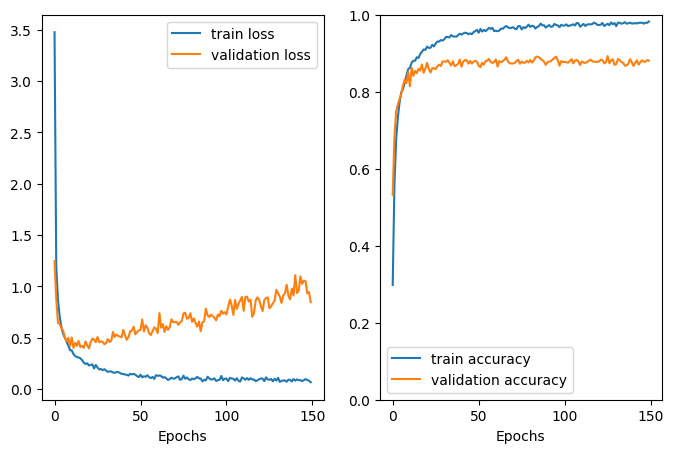

In [48]:
metrics = history.history


fig, ax = plt.subplots(1, 2)

ax[0].plot(history.epoch, metrics['loss'], metrics['val_loss'])
ax[0].set_xlabel('Epochs')
ax[0].legend(['train loss', 'validation loss'])


ax[1].plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
#plt.plot([x + 25 for x in history.epoch], metrics['accuracy'])
#plt.plot([x + 25 for x in history.epoch], metrics['val_accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylim([0, 1])
ax[1].legend(['train accuracy', 'validation accuracy'])

fig.set_size_inches(8, 5)
plt.show()



94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


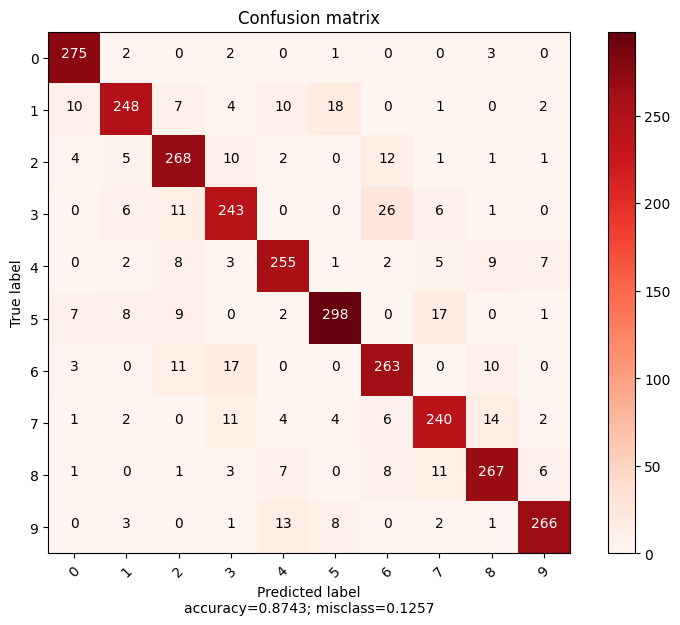

In [49]:
y_pred = model.predict(x_test_cur)

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = y_test

cm = confusion_matrix(true_categories,predicted_categories)
plot_confusion_matrix(cm, labels, normalize=False)


Classification Report

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       283
           1       0.90      0.83      0.86       300
           2       0.85      0.88      0.87       304
           3       0.83      0.83      0.83       293
           4       0.87      0.87      0.87       292
           5       0.90      0.87      0.89       342
           6       0.83      0.87      0.85       304
           7       0.85      0.85      0.85       284
           8       0.87      0.88      0.88       304
           9       0.93      0.90      0.92       294

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



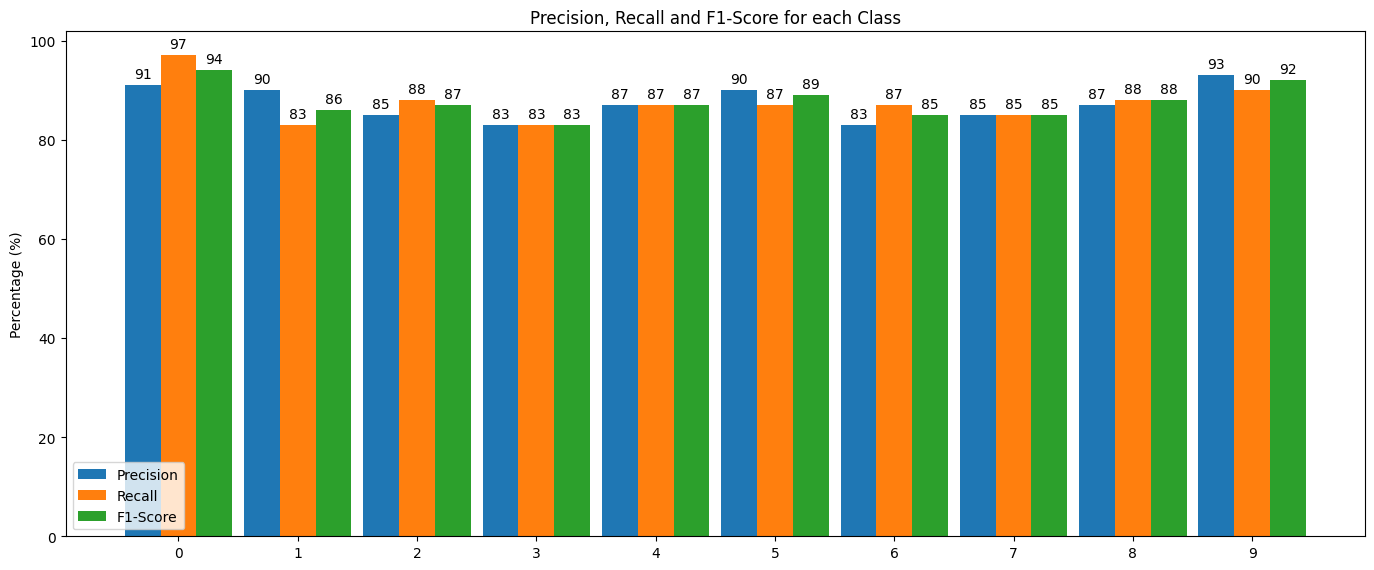

In [50]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
print('\nClassification Report\n')

cr = classification_report(true_categories, predicted_categories)
print(cr)


precision_score = np.round(precision_score(true_categories, predicted_categories, average=None),2)
recall_score = np.round(recall_score(true_categories, predicted_categories, average=None),2)
f1_score = np.round(f1_score(true_categories, predicted_categories, average=None),2)

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars


fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision_score*100, width, label='Precision')
rects2 = ax.bar(x , recall_score*100, width, label='Recall')
rects3 = ax.bar(x + width, f1_score*100, width, label='F1-Score')
 
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage (%)')
ax.set_title('Precision, Recall and F1-Score for each Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()
fig.set_size_inches(15, 6, forward=True)
plt.show()

In [ ]:
def record_audio():
    import pyaudio
    import wave

    chunk = 1024  # Record in chunks of 1024 samples
    sample_format = pyaudio.paInt16  # 16 bits per sample
    channels = 1
    fs = 8000  # Record at 44100 samples per second
    seconds = 2
    filename = "output.wav"

    p = pyaudio.PyAudio()  # Create an interface to PortAudio

    print('Recording')

    stream = p.open(format=sample_format,
                    channels=channels,
                    rate=fs,
                    frames_per_buffer=chunk,
                    input=True)

    frames = []  # Initialize array to store frames

    # Store data in chunks for 3 seconds
    for i in range(0, int(fs / chunk * seconds)):
        data = stream.read(chunk)
        frames.append(data)

    # Stop and close the stream 
    stream.stop_stream()
    stream.close()
    # Terminate the PortAudio interface
    p.terminate()

    print('Finished recording')

    # Save the recorded data as a WAV file
    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(sample_format))
    wf.setframerate(fs)
    wf.writeframes(b''.join(frames))
    wf.close()
    
# record_audio()

ALSA lib pcm_dsnoop.c:567:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1000:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:404:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:404:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_a52.c:1036:(_snd_pcm_a52_open) a52 is only for playback
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:481:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:481:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1000:(snd_pcm_dmix_open) unable to open slave


Recording
Finished recording


In [ ]:
rate, data = wavfile.read("output.wav")
print(data.shape)

trimmed_data = remove_silence(data.astype(float))

display(ipd.Audio(trimmed_data, rate=8000))

print(trimmed_data.shape)

print(max_size, trimmed_data.shape[0])

my_X = np.pad(trimmed_data, (0, max_size - trimmed_data.shape[0]))

my_spec = librosa.feature.mfcc(y=my_X, sr=8000)
print(my_spec.shape)

'''
y_pred = model.predict(my_spec.reshape(1, *my_spec.shape, 1))
predicted_categories = tf.argmax(y_pred, axis=1)
print(predicted_categories)
'''

prediction = model(my_spec.reshape(1,*my_spec.shape, 1))
plt.bar(labels, tf.nn.softmax(prediction[0]))
plt.title(f'Predictions for one')
plt.show()


(15360,)


(15360,)
12800 15360


ValueError: index can't contain negative values

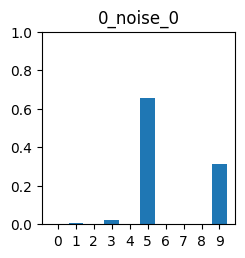

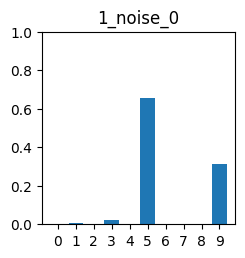

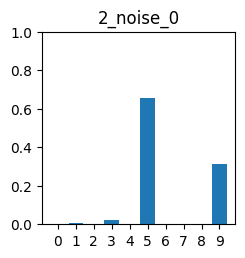

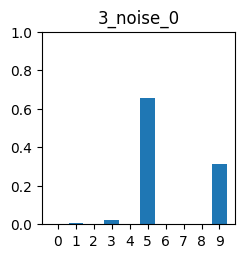

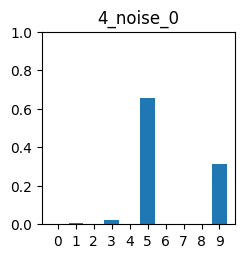

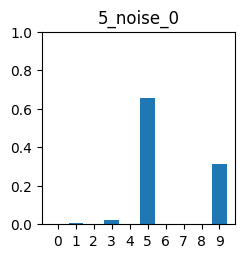

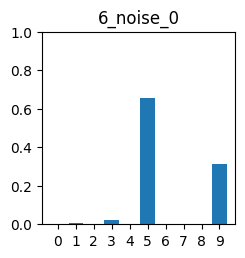

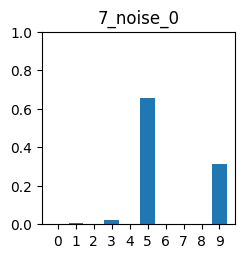

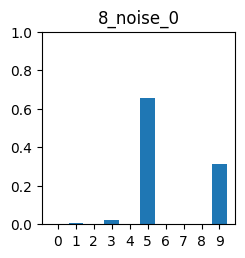

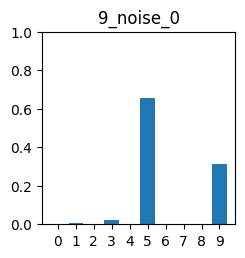

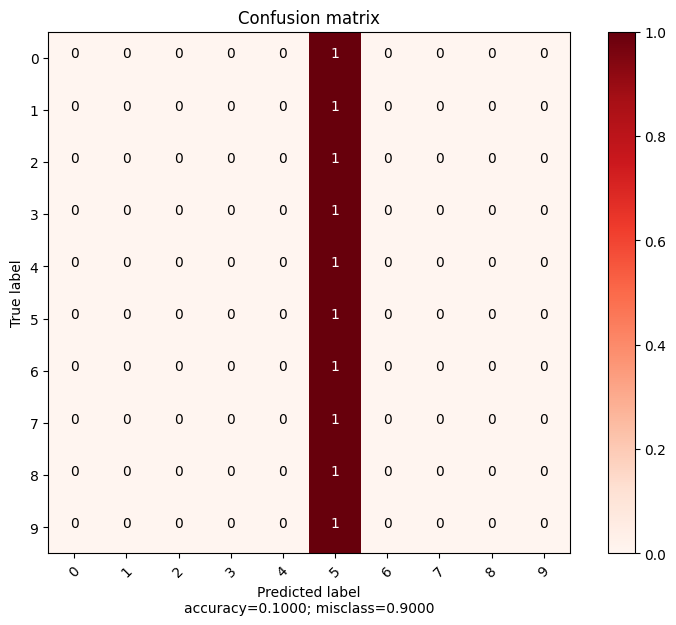

In [ ]:
files = 'new_recordings/'
ds_files = listdir(files)
ds_files.sort()

# divide files in labels
ds_chunks = [[file for file in ds_files if file.split("_")[0] == l] for l in labels  ]
    

predicted_categories = []
true_categories = []

for chunk in ds_chunks:
    
    fig, axes = plt.subplots(nrows=1, ncols=len(chunk), squeeze=False)
    sample = -1
    
    for file in chunk:
        label = int(file.split("_")[0])
        sample += 1
        
        ax = axes[0][sample]
        ax.set_ylim([0,1])

        rate, data = wavfile.read(join(files, file))

        #trimmed_data = trim_silence(data.astype(np.float16))
    
        trimmed_data = remove_silence(data.astype(float))

        display(ipd.Audio(trimmed_data, rate=8000))

        x = np.pad(trimmed_data, (0, max(max_size - trimmed_data.shape[0], trimmed_data.shape[0])))

        x_spec = librosa.feature.mfcc(y=x, sr=8000)

        
        (prediction,) = model(x_spec.reshape(1, *x_spec.shape, 1))
        ax.bar(labels, tf.nn.softmax(prediction))
        ax.set_title(f'{file[:-4]}')
        
        predicted_categories.append(tf.argmax(prediction))
        true_categories.append(label)
        
    fig.set_size_inches(2.5*len(chunk), 2.5, forward=True)
    plt.show()

    
cm = confusion_matrix(true_categories,predicted_categories)
plot_confusion_matrix(cm, labels, normalize=False)